# Assignment 1 - Beinwil (SO) die beste Gemeinde des Kantons Solothurn

In [2]:
import pandas as pd
import numpy as np
import warnings
import pdfplumber
import matplotlib.pyplot as plt

# Suppress openpyxl warnings
warnings.simplefilter("ignore", UserWarning)

# Gemeindestand
Quelle: https://www.agvchapp.bfs.admin.ch/de (XLSX)

Die Quelle für den aktuellen Gemeindestand enthält den Gemeindecode, den Gemeindenamen sowie den zugehörigen Kanton.
Mit dieser Quelle ist es somit möglich, herauszulesen, welche Gemeinden alle zum Kanton Solothurn gehören. Zudem ist das Aufnahmedatum der jeweiligen Gemeinden aufgelistet.

In [3]:
# Load data from Gemeindestand.xlsx
file_path_gemeindestand = "data/Gemeindestand.xlsx"
df_gemeindestand = pd.read_excel(file_path_gemeindestand, sheet_name="Daten", engine="openpyxl")

# Rename column for consistency
df_gemeindestand.rename(columns={"BFS Gde-nummer": "Gemeindecode"}, inplace=True)

#preview
df_gemeindestand.head()

,Hist.-Nummer,Kanton,Bezirks-nummer,Bezirksname,Gemeindecode,Gemeindename,Datum der Aufnahme
0,13256,ZH,101,Affoltern,1,Aeugst am Albis,1976-11-15
1,11742,ZH,101,Affoltern,2,Affoltern am Albis,1848-09-12
2,11801,ZH,101,Affoltern,3,Bonstetten,1848-09-12
3,11992,ZH,101,Affoltern,4,Hausen am Albis,1911-01-01
4,12249,ZH,101,Affoltern,5,Hedingen,1848-09-12


# Regionalportraits
Quelle: Bundesamt für Statistik, Regionalporträts 2021: https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/regionale-portraets-kennzahlen/gemeinden/daten-erlaeuterungen.assetdetail.15864450.html (XLSX)

Sehr grosser Datensatz, welcher Daten zu diversen thematiken der jeweiligen Gemeinden enthält.


In [4]:
# Load data from Regionalportraets.xlsx
file_path_regionalportraets = "data/Regionalportraets.xlsx"

# Skip the first 8 rows and set the header to none beacuse header is spread over multiple rows
df_regionalportraets = df = pd.read_excel(
    file_path_regionalportraets,
    skiprows=5,
    header=[0, 1],
    engine="openpyxl"
)

# Drop the rows which are all NaN
df_regionalportraets.dropna(how="all", inplace=True)

# Drop the row which was not specific to a Gemeinde
df_regionalportraets = df_regionalportraets.iloc[1:].reset_index(drop=True)

# Flatten the multiindex columns
df_regionalportraets.columns = [
    col[0] if pd.isna(col[1]) else f"{col[0]}_{col[1]}"
    for col in df_regionalportraets.columns
]

#Fix the header names for Gemeindecode and Gemeindename
df_regionalportraets.rename(columns={df_regionalportraets.columns[0]: 'Gemeindecode'}, inplace=True)
df_regionalportraets.rename(columns={df_regionalportraets.columns[1]: 'Gemeindename'}, inplace=True)

# Drop the rows at the bottom that are part of the legend
df_regionalportraets = df_regionalportraets[
    pd.to_numeric(df_regionalportraets["Gemeindecode"], errors="coerce").notna()
]


#preview
df_regionalportraets.head()


,Gemeindecode,Gemeindename,Einwohner_2019,Veränderung in %_2010-2019,Bevölkerungs-dichte pro km²_2019,Ausländer in %_2019,0-19 Jahre_2019,20-64 Jahre_2019,65 Jahre und mehr_2019,Rohe Heiratssziffer_2019,...,FDP 2)_2019,CVP_2019,SP_2019,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,PdA/Sol._2019,GPS_2019,Kleine Rechtsparteien_2019
0,1,Aeugst am Albis,1981.0,8.607456,250.442478,14.184755,19.787986,62.190813,18.021201,7.065355,...,16.421045,2.497974,11.565102,30.380959,3.22747,14.317294,1.263724,0.16211,15.050475,3.820647
1,2,Affoltern am Albis,12303.0,10.927779,1161.756374,28.700317,20.165813,61.667886,18.166301,5.543780,...,13.385437,4.535341,14.645255,30.30692,6.618556,12.666629,2.001445,0.198718,12.590564,1.555518
2,3,Bonstetten,5572.0,8.005427,749.932705,16.564968,23.636037,59.834889,16.529074,4.316547,...,15.354984,3.867961,16.742891,26.116313,4.194018,16.237935,1.28403,0.176013,12.368531,1.385022
3,4,Hausen am Albis,3751.0,11.636905,275.808824,16.022394,22.180752,59.824047,17.995201,3.220612,...,11.135163,3.934551,13.711509,33.18478,4.059761,12.416969,1.610747,0.19312,16.744127,1.610747
4,5,Hedingen,3778.0,10.791789,578.560490,16.410799,21.625199,61.646374,16.728428,3.727370,...,13.990898,3.87366,16.738323,26.601791,3.726851,16.415344,1.881252,0.182463,12.348734,2.170676


# Merged Dataframe
Im df_merged werden alle Daten in ein Dataframe zusammengetragen.
So muss bei der Analyse nur ein Datensatz verwendet werden.

In [5]:
 # Make sure the id is an integer
df_gemeindestand["Gemeindecode"] = df_gemeindestand["Gemeindecode"].astype(int)
df_regionalportraets["Gemeindecode"] = df_regionalportraets["Gemeindecode"].astype(int)

# Merge the two dataframes on Gemeindecode
df_merged = pd.merge(
    df_gemeindestand,
    df_regionalportraets,
    on=["Gemeindecode", "Gemeindename"],
    how="outer"
)

# Filter out all entries that are not Solothurn
df_merged = df_merged[df_merged["Kanton"] == "SO"]

# Make sure the datatype is correct
columns_to_clean = ["Beschäftigte total_2018", "im 1. Sektor_2018", "im 2. Sektor_2018" , "im 3. Sektor_2018"]
for col in columns_to_clean:
     df_merged[col] = df_merged[col].astype(str).replace("X", "0").astype(int)

df_merged.head()

,Hist.-Nummer,Kanton,Bezirks-nummer,Bezirksname,Gemeindecode,Gemeindename,Datum der Aufnahme,Einwohner_2019,Veränderung in %_2010-2019,Bevölkerungs-dichte pro km²_2019,...,FDP 2)_2019,CVP_2019,SP_2019,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,PdA/Sol._2019,GPS_2019,Kleine Rechtsparteien_2019
792,13703.0,SO,1101.0,Gäu,2401,Egerkingen,1991-01-01,3793.0,20.950255,545.755396,...,30.280338,21.639785,7.162058,28.149002,0.94086,3.955453,1.689708,*,4.781106,0.576037
793,13704.0,SO,1101.0,Gäu,2402,Härkingen,1991-01-01,1638.0,22.972973,297.277677,...,17.233633,15.564827,8.985879,39.28113,0.93068,10.077022,1.957638,*,4.525032,1.091142
794,13705.0,SO,1101.0,Gäu,2403,Kestenholz,1991-01-01,1829.0,10.114389,212.922002,...,18.032787,29.557132,11.279667,25.397602,0.78297,5.529728,1.541473,*,6.728652,0.56276
795,13706.0,SO,1101.0,Gäu,2404,Neuendorf,1991-01-01,2246.0,18.397470,314.565826,...,15.652784,28.380908,8.18905,31.586336,1.450632,5.662143,3.135236,*,4.585868,0.935891
796,13707.0,SO,1101.0,Gäu,2405,Niederbuchsiten,1991-01-01,1246.0,29.927007,226.958106,...,16.442308,30.913462,4.471154,36.923077,1.153846,4.519231,0.865385,*,3.173077,0.769231


# Polizeiliche Kriminalitätsstatistik
Quelle: https://so.ch/verwaltung/departement-des-innern/polizei/ueber-uns/statistiken-jahreszahlen/polizeiliche-kriminalstatistik/ (PDF)

In diesem PDF findet sich die Polizeiliche Kriminalitätstatistik vom Jahr 2023.

Es wurde entschieden, dass die Daten zu den Anzahl Straffällen im Jahr 2023 am relevatesten sind. Im folgenden Code wurde deshalb diese Tabelle extrahiert und bereinigt bis nur noch die relevanten Daten vorhanden sind.

In [6]:
pdf_path = 'data/PKS_2023_SO.pdf'

# Open the PDF and extract the table
with pdfplumber.open(pdf_path) as pdf:
    page = pdf.pages[67] # zero-based index
    table = page.extract_table()

# convert the table to a DataFrame - skip the first 4 rows, the row with index 3 is the header
df_crime = pd.DataFrame(table[4:], columns=table[3])

# Remove whitespaces from the columns
for col in df_crime.columns[1:]:
    df_crime[col] = df_crime[col].str.replace(' ', '')

# Drop all data except for the newest
df_crime = df_crime.drop(df_crime.columns[1:7], axis=1)

# Set the correct column headers
df_crime = df_crime.rename(columns={df_crime.columns[0]: 'Gemeindename', df_crime.columns[1]: 'Straftaten'})

# Drop the rows at the bottom that are part of the legend
df_crime = df_crime[
    pd.to_numeric(df_crime["Straftaten"], errors="coerce").notna()
]

# Display the first few rows of the DataFrame
df_crime.to_excel("data/crime_data.xlsx", index=False)
print(df_crime.head())


  Gemeindename Straftaten
0    Solothurn       3861
1        Olten       2942
2     Grenchen       1839
3      Zuchwil        789
4     Biberist        707


# Polizeiliche Kriminalitätsstatistik - Übringe Gemeinden
Da im PDF nur die grossen Gemeinden explizit gelistet sind, sind die kleinen Gemeinden in "Übrige Gemeinden gelistet".
Es wurde die Annahme getroffen, dass die Straftaten der übrigen Gemeinden im Verhältnis zu den Einwohnern verteilt sind.

In [7]:
# Extract all the Einwohner and Gemeinden that are not explicitly listed on the crime data
df_temp = df_merged[['Gemeindename', 'Einwohner_2019']].copy()
df_temp = df_temp[~df_temp['Gemeindename'].isin(df_crime['Gemeindename'])]

# Calculate Straftaten per Einwohner for the remaining Gemeinden
total_einwohner = df_temp['Einwohner_2019'].sum()
straftaten = (df_crime.loc[df_crime['Gemeindename'] == 'Übrige Gemeinden', 'Straftaten']).astype(int)
straftaten_pro_einwohner = straftaten / total_einwohner

# make sure straftaten_pro_einwohner is scalar
straftaten_pro_einwohner = straftaten_pro_einwohner.values[0] if not straftaten_pro_einwohner.empty else 0

# Add the probable Straftaten to the according Gemeinde in df_temp
df_temp['Straftaten'] = (df_temp['Einwohner_2019'] * straftaten_pro_einwohner).astype(int)

# Insert the missing Gemeinden to the df_crime
df_crime = df_crime[df_crime['Gemeindename'] != 'Übrige Gemeinden']
df_crime = pd.concat([df_crime, df_temp[['Gemeindename', 'Straftaten']]], ignore_index=True)

# Make sure the Straftaten column is an int
df_crime['Straftaten'] = df_crime['Straftaten'].astype(int)

# Merge the crime data into the df_merged
df_merged = df_merged.merge(df_crime[['Gemeindename', 'Straftaten']], on='Gemeindename', how='left')



# Daten plotting
In den folgenden Feldern werden diverse Daten geplottet um einen besseren Eindruck zu bekommen

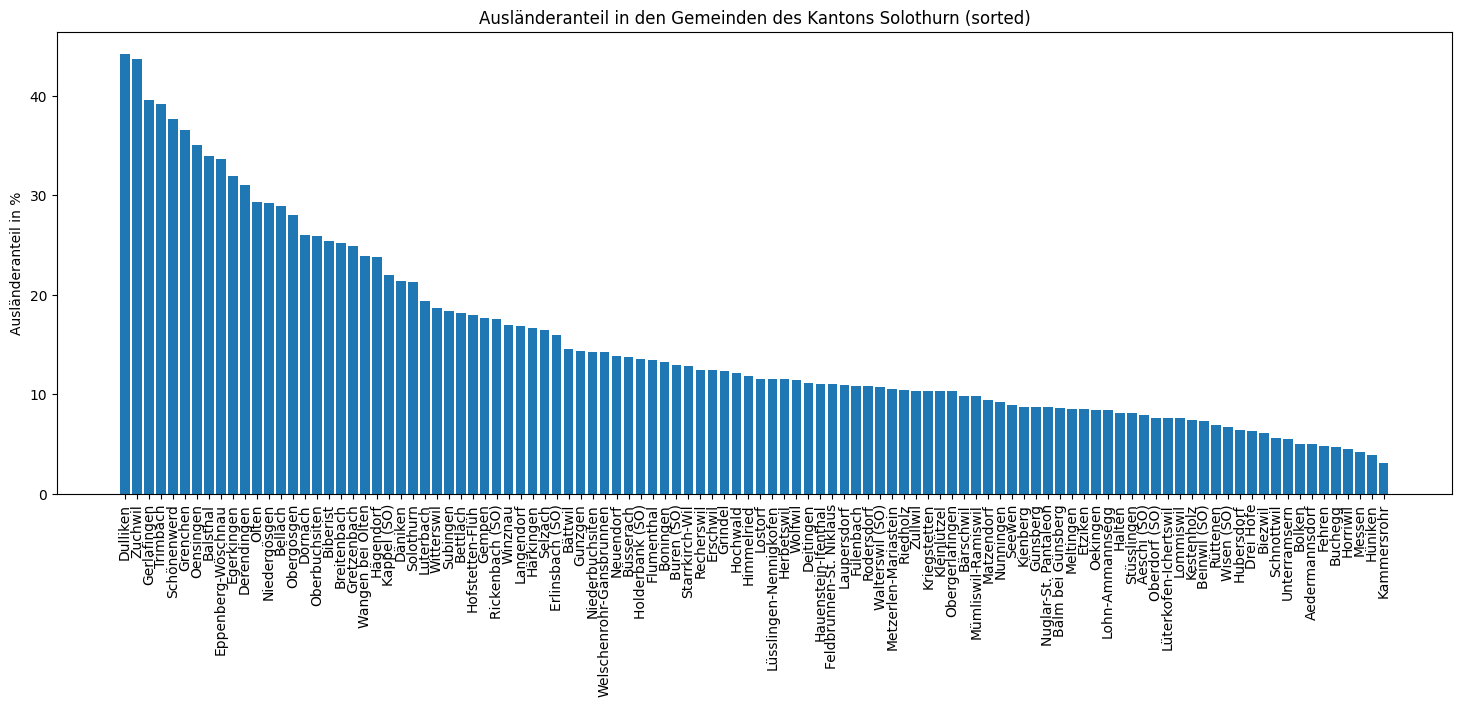

In [8]:
df_merged_sorted = df_merged.sort_values(by="Ausländer in %_2019", ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(df_merged_sorted["Gemeindename"], df_merged_sorted["Ausländer in %_2019"])
plt.xticks(rotation=90)
plt.ylabel("Ausländeranteil in %")
plt.title("Ausländeranteil in den Gemeinden des Kantons Solothurn (sorted)")

plt.show()




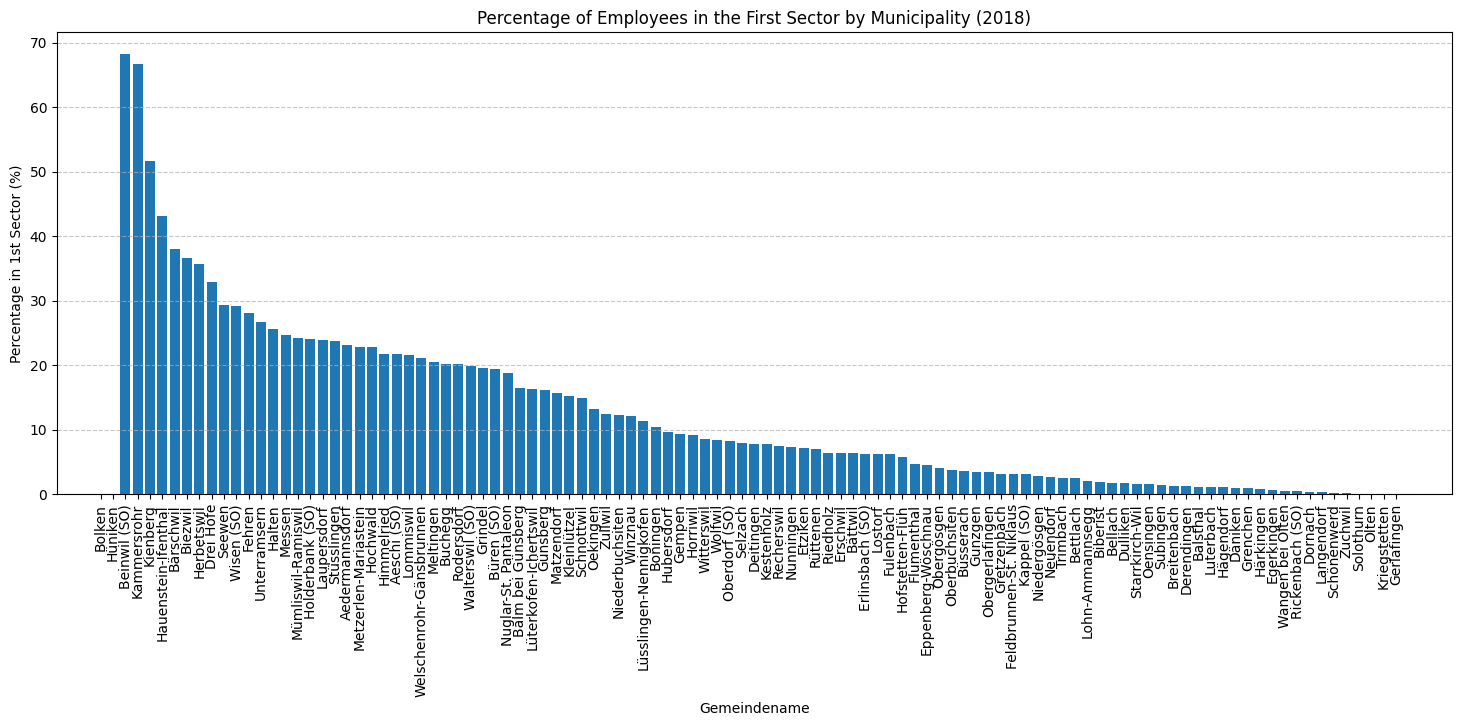

In [9]:
# Calculate the percentage of employees in the first sector
df_merged["percentage_first_sector"] = (df_merged["im 1. Sektor_2018"] / df_merged["Beschäftigte total_2018"]) * 100

df_merged = df_merged.sort_values(by="percentage_first_sector", ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(df_merged["Gemeindename"], df_merged["percentage_first_sector"])
plt.xlabel("Gemeindename")
plt.ylabel("Percentage in 1st Sector (%)")
plt.title("Percentage of Employees in the First Sector by Municipality (2018)")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


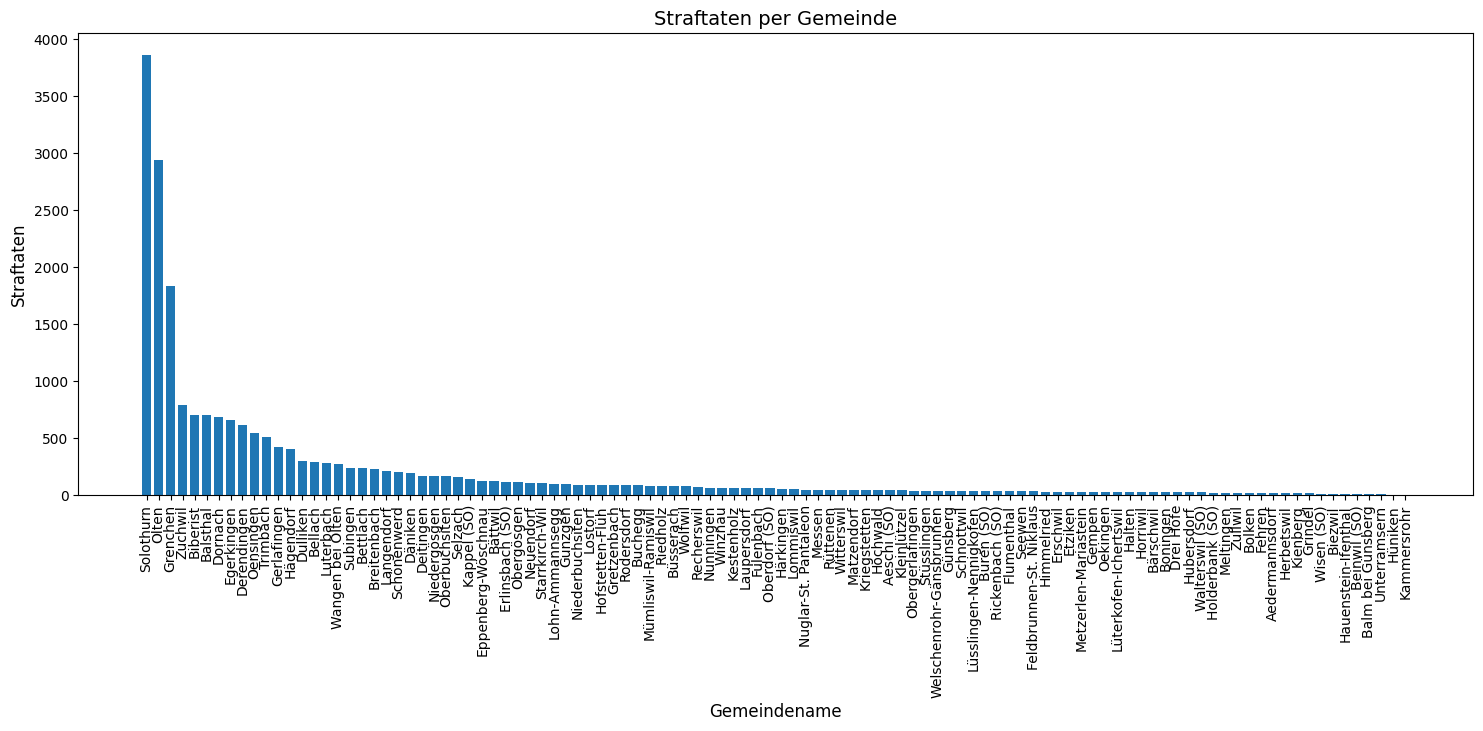

In [10]:
df_merged_sorted = df_merged.sort_values(by="Straftaten", ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(df_merged_sorted["Gemeindename"], df_merged_sorted["Straftaten"])

plt.xlabel("Gemeindename", fontsize=12)
plt.ylabel("Straftaten", fontsize=12)
plt.title("Straftaten per Gemeinde", fontsize=14)
plt.xticks(rotation=90)

plt.show()


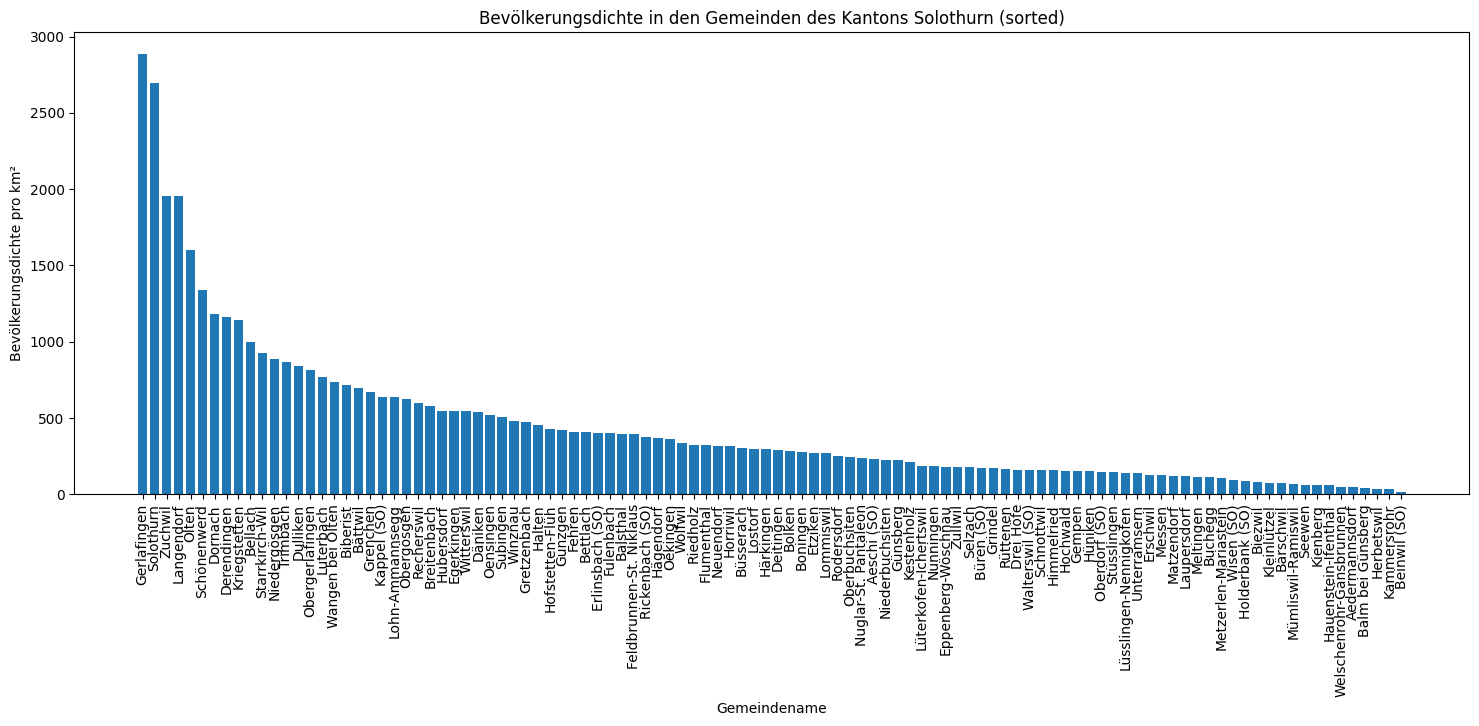

In [50]:
df_merged_sorted = df_merged.sort_values(by="Bevölkerungs-dichte pro km²_2019", ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(df_merged_sorted["Gemeindename"], df_merged_sorted["Bevölkerungs-dichte pro km²_2019"])
plt.xticks(rotation=90)
plt.xlabel("Gemeindename")
plt.ylabel("Bevölkerungsdichte pro km²")
plt.title("Bevölkerungsdichte in den Gemeinden des Kantons Solothurn (sorted)")

plt.show()

# Ranking

In diesem Abschnitt wird ein Ranking erstellt, welches die Gemeinden nach den folgenden Kriterien bewertet:
1. Anteil der Bauern
2. Anteil der Schweizer
3. Anzahl der Straftaten
4. Bevölkerungsdichte

In jedem Ranking kann eine Gemeinde maximal 100 Punkte erreichen. Die Punkte werden dann summiert, normalisiert und die Gemeinden werden nach der Gesamtpunktzahl sortiert.

Schritte zur hervorhebung der besten Gemeinde:
Beinwil (SO) ist eine kleine Gemeinde (275 Einwohner) verglichen mit den Nachbarn (alphabetisch) Bellach (5284 Einwohner) und Balsthal(6239 Einwohner). Deshalb wurden bei den "positiven" Attributen wie Bauern und Schweizern der Prozentsatz gewertet. Bei dem "negativen" attribut Straftaten wurde die effektive Anzahl der Straftaten gewertet. Diese wurde dann in Kategorien eingeteilt, um den Effekt noch weiter zu verstärken. Die Bevölkerungsdichte wurde ebenfalls gewertet, da Beinwil (SO) wenig Einwohner aber eine verhältnismässig grosse Fläche hat. Zudem wurden die Ausländer doppelt gewichtet, um den Abstand zu den Nachbarn noch weiter zu vergrössern. Um den Sieg gegenüber Kammersrohr zu gewährleisten, war Bevölkerungsdichte essenziell.

                 Gemeindename  Bauern  Schweizer  Kriminelle  Dichte  Total_Score  Rank_Bauern  Rank_Schweizer  Rank_Kriminelle  Rank_Dichte  Rank
95               Beinwil (SO)    68.0       85.0         100    88.0           85            1               9                1            1     1
71                Kammersrohr    67.0       94.0         100    66.0           82            2               1                1            2     2
10                 Herbetswil    36.0       77.0          90    65.0           67            7              17                2            3     3
63          Balm bei Günsberg    17.0       83.0         100    62.0           66           20              11                1            4     4
35                   Kienberg    52.0       83.0          90    41.0           66            3              11                2            8     4
8              Aedermannsdorf    23.0       90.0          90    55.0           64           15               4        

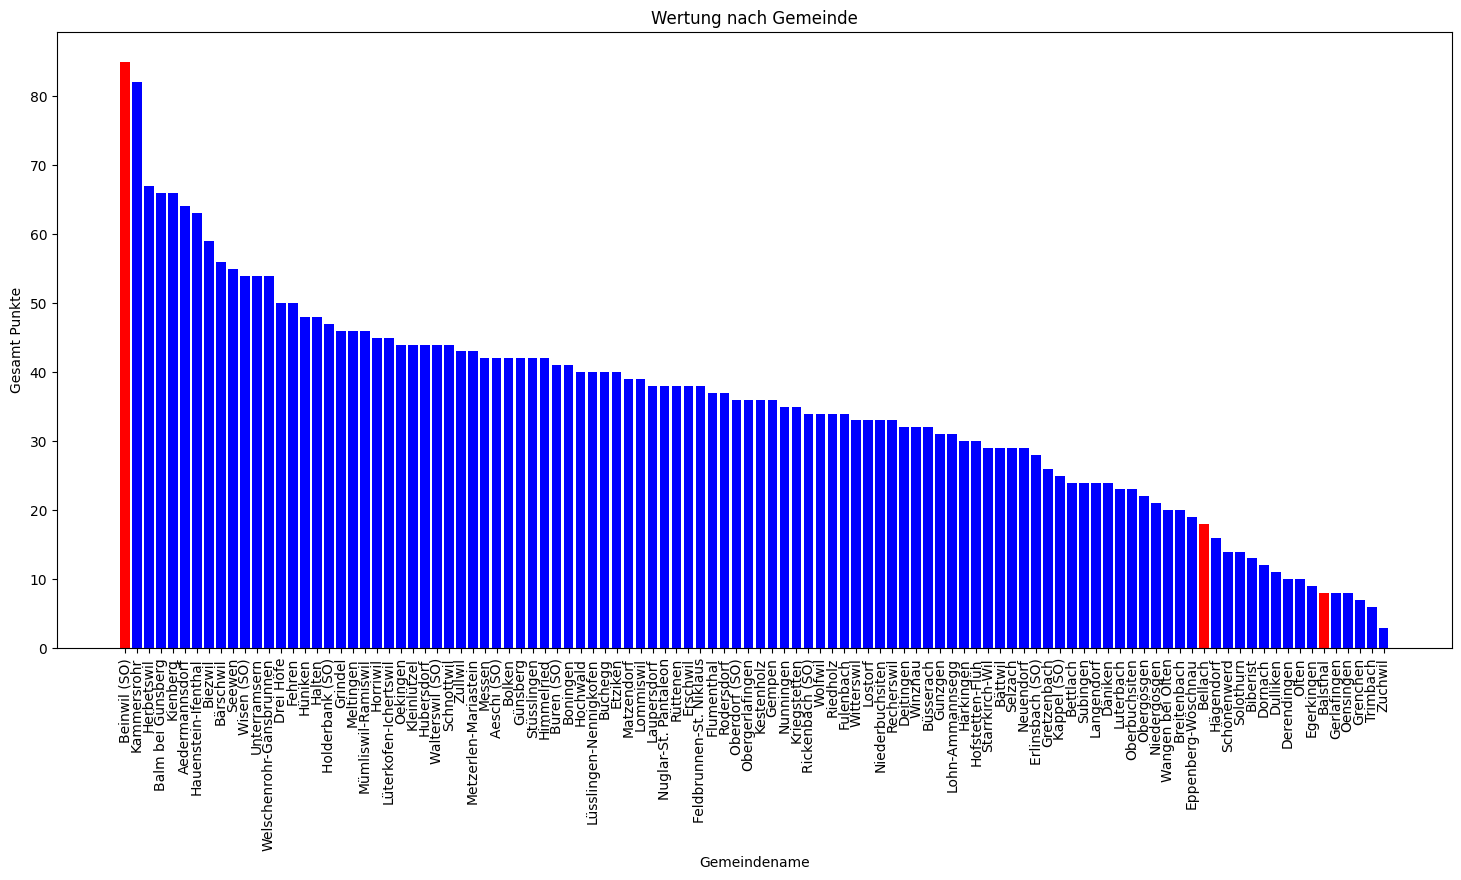

In [45]:
df_ranking = df_merged[['Gemeindename']].copy()
df_ranking = df_ranking.sort_values(by="Gemeindename", ascending=True)


crime_col = "Straftaten"

# Create Ranking for the first criteria - Amount of Farmers
df_ranking["Bauern"] = df_merged["percentage_first_sector"]
df_ranking["Bauern"] = df_ranking["Bauern"].replace([np.inf, -np.inf], 0).fillna(0)
df_ranking["Bauern"] = np.round(df_ranking["Bauern"])

# Create Ranking for the second criteria - Amount of Swiss People
df_ranking["Schweizer"] = 100 - (df_merged["Ausländer in %_2019"] * 2)
df_ranking["Schweizer"] = np.round(df_ranking["Schweizer"])

# Create Ranking for the third criteria - Amount of Criminals
df_ranking["Kriminelle"] = pd.to_numeric(df_merged["Straftaten"], errors="coerce")
# Apply categorization based on my rule
df_ranking["Kriminelle"] = np.select(
    [
        df_ranking["Kriminelle"] < 10,
        df_ranking["Kriminelle"] < 20,
        df_ranking["Kriminelle"] < 30,
        df_ranking["Kriminelle"] < 40,
        df_ranking["Kriminelle"] < 50,
        df_ranking["Kriminelle"] < 100,
        df_ranking["Kriminelle"] < 200,
        df_ranking["Kriminelle"] < 300,
        df_ranking["Kriminelle"] < 400,
        df_ranking["Kriminelle"] < 500
    ],
    [100, 90, 80, 70, 60, 50, 40, 30, 20, 10],
    default=0  # More than 500 gets 0 points
)

df_ranking["Dichte"] = 100 - df_merged["Bevölkerungs-dichte pro km²_2019"]
df_ranking["Dichte"] = df_ranking["Dichte"].clip(lower=0, upper=100)
df_ranking["Dichte"] = np.round(df_ranking["Dichte"])

# Give the Total_Score
score_columns = ["Bauern", "Schweizer", "Kriminelle", "Dichte"]

df_ranking["Total_Score"] = df_ranking[score_columns].sum(axis=1)/len(score_columns)
df_ranking["Total_Score"] = np.round(df_ranking["Total_Score"])
df_ranking["Total_Score"] = df_ranking["Total_Score"].astype(int)

# Give Rank according to the score
# Calculate the rank for each category
df_ranking["Rank_Bauern"] = df_ranking["Bauern"].rank(method="dense", ascending=False).astype(int)
df_ranking["Rank_Schweizer"] = df_ranking["Schweizer"].rank(method="dense", ascending=False).astype(int)
df_ranking["Rank_Kriminelle"] = df_ranking["Kriminelle"].rank(method="dense", ascending=False).astype(int)
df_ranking["Rank_Dichte"] = df_ranking["Dichte"].rank(method="dense", ascending=False).astype(int)
df_ranking["Rank"] = df_ranking["Total_Score"].rank(method="dense", ascending=False).astype(int)

# Select Beinwil and the two Nachbargemeinden
selected_gemeinden = ["Beinwil (SO)", "Bellach", "Balsthal"]

# Sort by Ranking, print and plot
df_ranking = df_ranking.sort_values(by="Total_Score", ascending=False)
print(df_ranking.to_string())

plt.figure(figsize=(18, 8))
colors = ['red' if gemeinde in selected_gemeinden else 'blue' for gemeinde in df_ranking["Gemeindename"]]
plt.bar(df_ranking["Gemeindename"], df_ranking["Total_Score"], color=colors)
plt.xticks(rotation=90)
plt.xlabel("Gemeindename")
plt.ylabel("Gesamt Punkte")
plt.title("Wertung nach Gemeinde")

plt.show()

# Vergleich von Beinwil mit den Nachbarsgemeinden

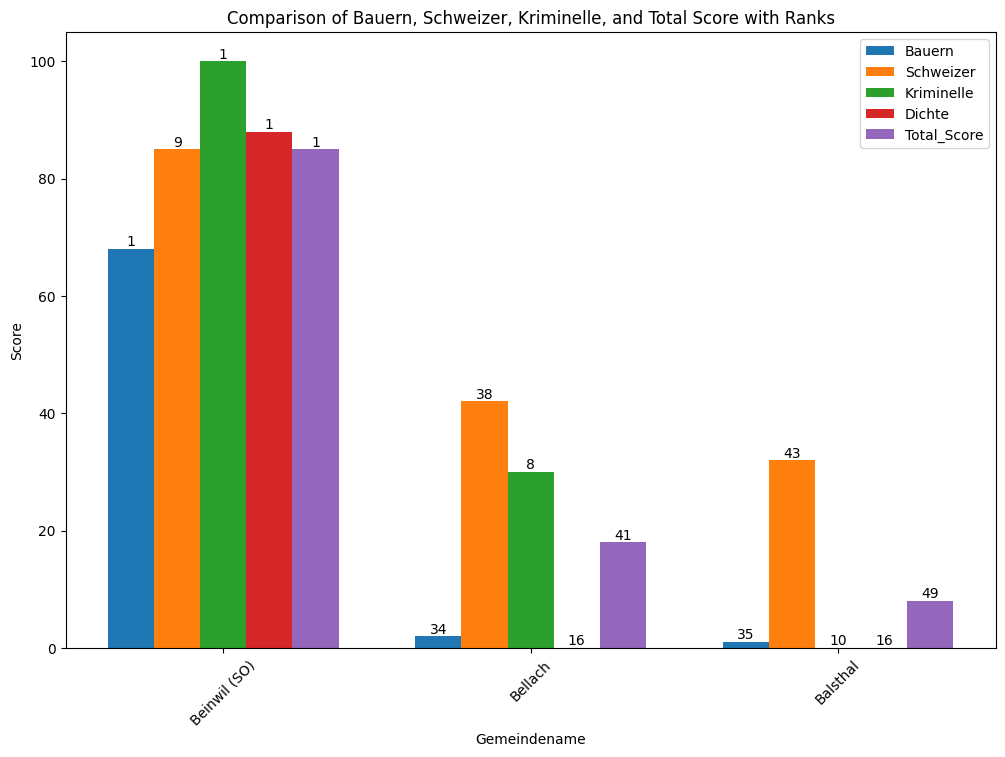

In [35]:
df_selected = df_ranking[df_ranking["Gemeindename"].isin(selected_gemeinden)]

# Define the score columns and corresponding rank columns
score_columns = ["Bauern", "Schweizer", "Kriminelle", "Dichte", "Total_Score"]
rank_columns = ["Rank_Bauern", "Rank_Schweizer", "Rank_Kriminelle", "Rank_Dichte", "Rank"]

x = np.arange(len(df_selected))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

for i, col in enumerate(score_columns):
    bars = ax.bar(x + i * bar_width, df_selected[col], width=bar_width, label=col)
    for bar, rank in zip(bars, df_selected[rank_columns[i]]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rank}', ha='center', va='bottom')

ax.set_xticks(x + bar_width * (len(score_columns) / 2 - 0.5))
ax.set_xticklabels(df_selected["Gemeindename"], rotation=45)
ax.set_xlabel("Gemeindename")
ax.set_ylabel("Score")
ax.set_title("Comparison of Bauern, Schweizer, Kriminelle, and Total Score with Ranks")
ax.legend()

plt.show()

# Plots für den Bericht
Die folgenen Visualisierungen wurden für den Bericht erstellt.

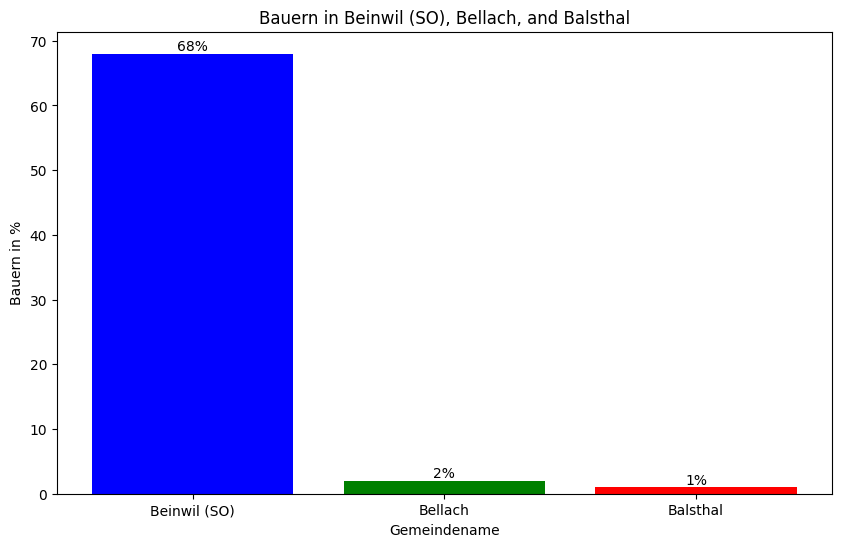

In [39]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_selected["Gemeindename"], df_selected["Bauern"], color=['blue', 'green', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}%', ha='center', va='bottom')

plt.xlabel("Gemeindename")
plt.ylabel("Bauern in %")
plt.title("Bauern in Beinwil (SO), Bellach, and Balsthal")
plt.show()

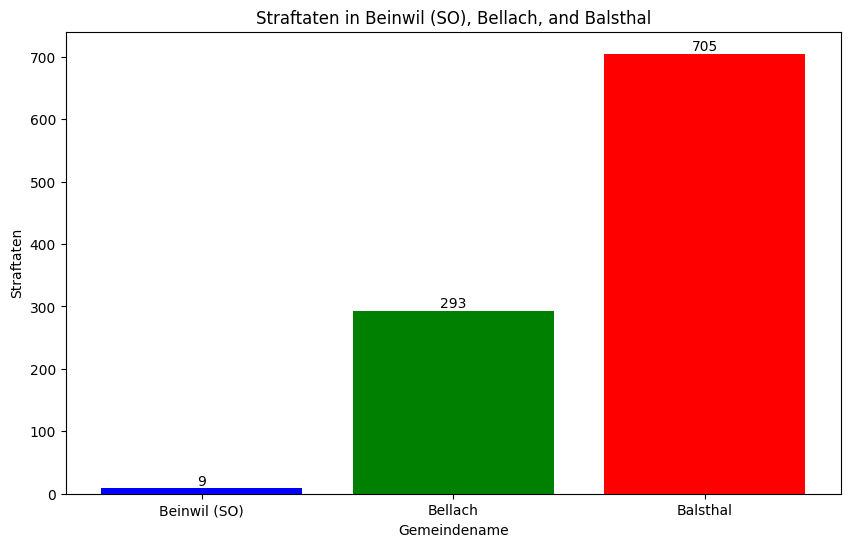

In [42]:
df_selected_merged = df_merged[df_merged["Gemeindename"].isin(selected_gemeinden)]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_selected_merged["Gemeindename"], df_selected_merged["Straftaten"], color=['blue', 'green', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.xlabel("Gemeindename")
plt.ylabel("Straftaten")
plt.title("Straftaten in Beinwil (SO), Bellach, and Balsthal")
plt.show()

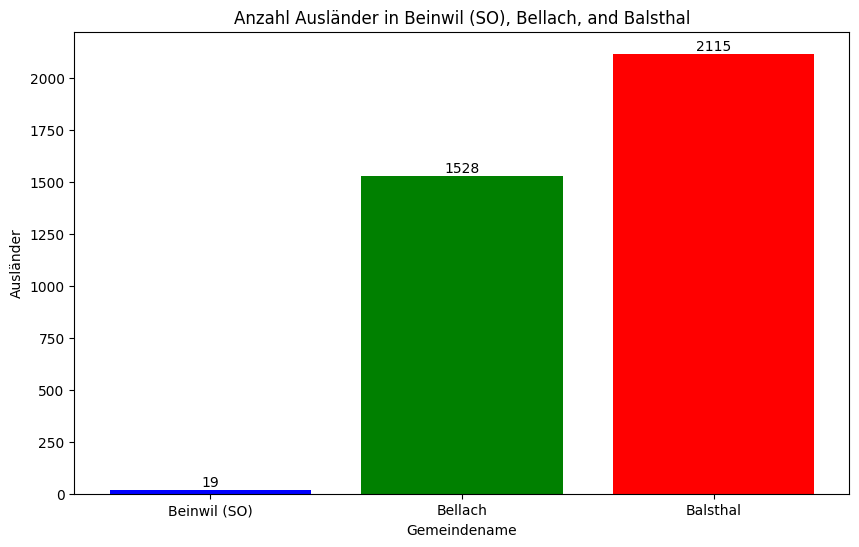

In [49]:
# Calculate the absolute value of Ausländer
df_selected_merged.loc[:, "Ausländer2019"] = (df_selected_merged["Einwohner_2019"] * df_selected_merged["Ausländer in %_2019"] / 100).astype(int)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_selected_merged["Gemeindename"], df_selected_merged["Ausländer2019"], color=['blue', 'green', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')

plt.xlabel("Gemeindename")
plt.ylabel("Ausländer")
plt.title("Anzahl Ausländer in Beinwil (SO), Bellach, and Balsthal")
plt.show()